CNN   Vgg16  transferencia de aprendizaje

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("dividido"))

['test', 'train', 'val']


### Importar Librerias

In [4]:
from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

### Explorando Datos

Number of Images for Training:  2127
Number of Images for validating:  260
Number of Images for testing:  252
Number of classes:  2


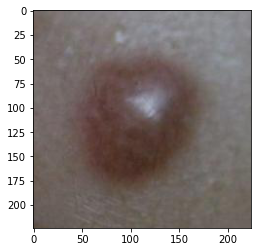

In [13]:
train_path = 'dividido/train'
valid_path = 'dividido/val'
test_path = 'dividido/test'
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
test_image_files = glob(valid_path + '/*/*.jp*g')
print("Number of Images for Training: ",len(image_files))
print("Number of Images for validating: ",len(glob(valid_path + '/*/*.jp*g')))
print("Number of Images for testing: ",len(glob(test_path + '/*/*.jp*g')))
folders = glob(train_path + '/*')
print("Number of classes: ",len(folders))
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [9]:
IMAGE_SIZE = [100, 100] 
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

### Definir optimizador y funciones de perdidas y precision

In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

gen = ImageDataGenerator(

  preprocessing_function=preprocess_input
)

Found 379 images belonging to 2 classes.
{'M': 0, 'N': 1}
min: -123.68 max: 119.32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


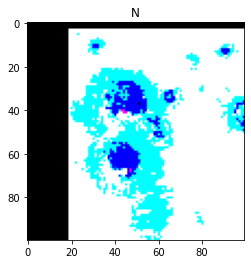

In [11]:
test_gen = gen.flow_from_directory(test_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [12]:
epochs = 5
batch_size = 32

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Found 3023 images belonging to 2 classes.
Found 376 images belonging to 2 classes.


C:\ProgramData\Anaconda3\envs\gpu_ok\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
66/66 [==============================] - 56s 491ms/step - loss: 3.2418 - accuracy: 0.7382 - val_loss: 1.7988 - val_accuracy: 0.7930
Epoch 2/5
66/66 [==============================] - 41s 618ms/step - loss: 1.1637 - accuracy: 0.8635 - val_loss: 0.8336 - val_accuracy: 0.9023
Epoch 3/5
66/66 [==============================] - 32s 481ms/step - loss: 0.7099 - accuracy: 0.9050 - val_loss: 1.4343 - val_accuracy: 0.8594
Epoch 4/5
66/66 [==============================] - 31s 462ms/step - loss: 0.5616 - accuracy: 0.9265 - val_loss: 0.8352 - val_accuracy: 0.8789
Epoch 5/5
66/66 [==============================] - 31s 469ms/step - loss: 0.4066 - accuracy: 0.9356 - val_loss: 0.9248 - val_accuracy: 0.8867


Generar metricas

In [36]:
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    acsc=accuracy_score(targets, predictions)
    return cm, acsc,predictions,targets

cm,ascs,z,zz = get_confusion_matrix(train_path, len(image_files))
print(cm,ascs)
valid_cm,valid_ascs,z,zz = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm,valid_ascs)
test_cm, test_ascs,y_pred,y_true = get_confusion_matrix(test_path, len(test_image_files))
print(test_cm,test_ascs)
print(classification_report(y_true, y_pred, target_names=labels))


Generating confusion matrix 2127
Found 3023 images belonging to 2 classes.
[[1160   16]
 [  98  902]] 0.9476102941176471
Generating confusion matrix 260
Found 376 images belonging to 2 classes.
[[133  11]
 [ 33 143]] 0.8625
Generating confusion matrix 260
Found 379 images belonging to 2 classes.
[[136  13]
 [ 33 138]] 0.85625
              precision    recall  f1-score   support

           M       0.80      0.91      0.86       149
           N       0.91      0.81      0.86       171

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320



Mostrar graficos de entrenamiento

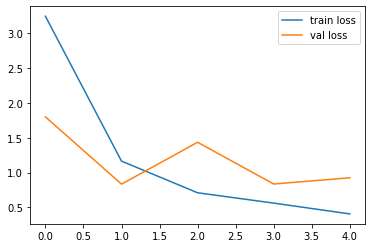

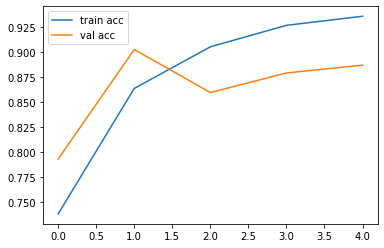

In [18]:
# plot Loss and Accuracies

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


Mostrar matrices de confusion

Confusion matrix, without normalization
[[1160   16]
 [  98  902]]


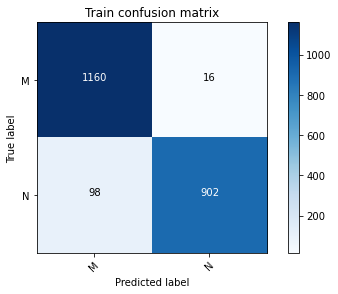

Confusion matrix, without normalization
[[133  11]
 [ 33 143]]


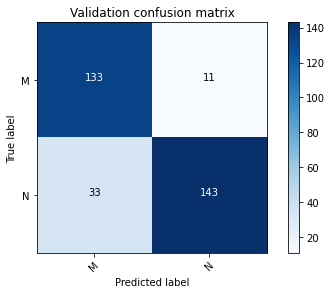

Confusion matrix, without normalization
[[136  13]
 [ 33 138]]


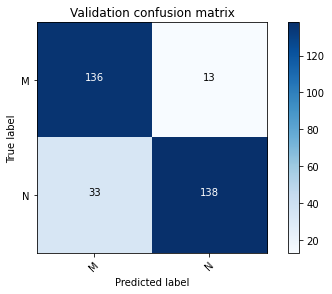

In [19]:
# Plot Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')
plot_confusion_matrix(test_cm, labels, title='Validation confusion matrix')